# 05. Machine Learning for music playlists: K-nearest neighbors classification
This is the 5th post in a series of posts devoted to building music playlists with Scikit-Learn tools.   
The purpose of the analysis is to detect tracks in my iTunes music library that would suit my fitness practices, which are "ballet", "cycling", and "yoga". To solve that problem I use ML classification algorithms. 

Previous posts cover the following steps:
* [00_Overview](https://github.com/Tykovka/itunes-music-analysis/blob/master/00_Overview.ipynb) — Overview of the analysis, its goals and methods, installation notes.  
* [01_Data_preparation](https://github.com/Tykovka/itunes-music-analysis/blob/master/01_Data_preparation.ipynb) — Data gathering and cleaning.  
* [02_Data_visualisation](https://github.com/Tykovka/itunes-music-analysis/blob/master/02_Data_Visualisation.ipynb) — Visualisation and overview of data.  
* [03_Preprocessing](https://github.com/Tykovka/itunes-music-analysis/blob/master/03_Preprocessing.ipynb) — Data preprocessing to use it as input for Scikit-learn ML algorithms. 
* [04_Novelty_detection](https://github.com/Tykovka/itunes-music-analysis/blob/master/04_Novelty_detection.ipynb) — One-Class SVM algorithm to identify matching tracks in the non-labelled dataset.

As a result of previous manipulations I have the following datasets in HDF5 format: 
* training set contains 143 tracks labelled with one of the three classes: "ballet", "cycling", "yoga";
* test set contains 536 tracks, where 408 tracks are labelled as matching the training set and 128 tracks as non-matching. In the [04_Novelty_detection](https://github.com/Tykovka/itunes-music-analysis/blob/master/04_Novelty_detection.ipynb) notebook, I used One-Class SVM algorithm to choose tracks in the test set that match the training data. As a result, each track was identified either as matching (label "1") or not (label "-1").

Both datasets are stored as numpy arrays of standardised data. Target labels are stored as a numpy array in HDF5 file as well.

In this post, I apply [k neighbours classification](http://scikit-learn.org/stable/modules/neighbors.html#classification) to assign every track in the matching group one of the classes. 

#### Contents of the notebook
* [Tune parameters using GridSearchCV](#1.-Tune-parameters-using-GridSearchCV)
* [Create and train the model](#2.-Create-and-train-the-model)
* [Estimate model accuracy score](#3.-Estimate-model-accuracy-score)
* [Make predictions and estimate probability](#4.-Make-predictions-and-estimate-probability)
* [Record the result to the set and DF](#5.-Record-the-result)
* [Review the results](#6.-Review-the-result)
* [Apply probability threshold](#7.-Apply-probability-threshold)
* [Summary](#Summary)

I start with importing modules required in the notebook.

In [1]:
# the future division statement
from __future__ import division

from IPython.display import display
import numpy as np

#### Read in data
In this notebook, I use preprocessed data, which are numpy arrays of standardised data.  
I store data in HDF5 file format. To read it I use h5py library.

In [2]:
import h5py

# open the file 'music_data.h5' in read-only mode
with h5py.File('music_data.h5','r') as hf:
    train_std = np.array(hf.get('train_std'))
    target = np.array(hf.get('target'))
    test_svm = np.array(hf.get('test_svm'))

In [3]:
# shape of sets
print "Training set:", train_std.shape
print "Test set:", test_svm.shape

Training set: (143, 11)
Test set: (536, 12)


In [4]:
labels = ['ballet', 'cycling', 'yoga']

I create a separate array with matching tracks that are labelled with "1". I also save index of these rows as a numpy array. Thus, it will be easier to identify each track after classification, where I'll be using only tracks labelled as matching.

In [5]:
# original index of matching rows
indx = np.where(test_svm[:, 11] == 1)[0]

In [6]:
# matching tracks
# leave a column with a matching label out
test_match = test_svm[indx, 0:11]

In [7]:
print "Data overview: "
print "Train data shape:", train_std.shape
print "Test data shape:", test_svm.shape
print "Test data only with matching tracks:", test_match.shape

Data overview: 
Train data shape: (143, 11)
Test data shape: (536, 12)
Test data only with matching tracks: (408, 11)


## K-nearest neighbors classification
Nearest neighbors classification algorithm computes a class for every query point (that is, non-labelled observation) based on a simple majority of class representatives within the nearest labelled neighbors. In Scikit_Learn [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) number of nearest neighbors of each query point — *k* — is specified in model parameters.

In [8]:
# nearest neighbours algorithm
from sklearn import neighbors

### 1. Tune parameters using GridSearchCV
[GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) performs an exhaustive search over specified parameter values for an estimator. I use it to test the desired range of input parameters, and review the performance of each set of values on a cross-validation basis. 

In [9]:
from sklearn.grid_search import GridSearchCV

# set the range of input parameters
parameter_grid = {'n_neighbors': [3, 5, 7],
                  'weights': ['uniform', 'distance'],
                 'algorithm': ['auto', 'ball_tree', 
                               'kd_tree', 'brute']}

# set the algorithm
grid_search = GridSearchCV(neighbors.KNeighborsClassifier(), 
                           parameter_grid, cv=6)

grid_search.fit(train_std, target)

# review the result
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

[mean: 0.75524, std: 0.05422, params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.75524, std: 0.08539, params: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.75524, std: 0.05422, params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree'},
 mean: 0.75524, std: 0.08539, params: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree'},
 mean: 0.75524, std: 0.05422, params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree'},
 mean: 0.75524, std: 0.08539, params: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree'},
 mean: 0.75524, std: 0.05422, params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute'},
 mean: 0.75524, std: 0.08539, params: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute'},
 mean: 0.76224, std: 0.04950, params: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.76224, std: 0.04950, params: {'n_neighbors': 3, 'weights': 'dist

In [10]:
# define the winner
knn_best_score = grid_search.best_score_
best_params = grid_search.best_params_

print ("The best-performing tuning parameters"
       "\nBest score: {0:.4f};"
       "\nBest parameters: {1}."
       .format(knn_best_score, 
               best_params
              ))

The best-performing tuning parameters
Best score: 0.7762;
Best parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto'}.


### 2. Create and train the model
Next, I create a model using the parameters defined by GridSearchCV.

In [11]:
# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], 
                                     weights=best_params['weights'], 
                                     algorithm=best_params['algorithm'])

# train the model
knn.fit(train_std, target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=7, p=2, weights='distance')

### 3. Estimate model accuracy score
One of the most important pieces of machine learning is model validation: that is, checking how well the model fits a given dataset. I can not automatically assess the accuracy of predictions made for the test set because it is non-labelled data. A better way to test a model is to use a hold-out part of the labelled set which doesn't enter the training.  

Scikit-Learn provides a great tool for model validation — [K-fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score) module, which splits the data into K chunks and performs K fits, where each chunk gets a turn as the validation set. K is defined by the cv parameter. I use 10-fold cross validation. 

In [12]:
from sklearn.cross_validation import cross_val_score

# calculate model accuracy score
cvs = cross_val_score(knn, train_std, target, 
                    scoring='accuracy', cv=10).mean()

In [13]:
# Build a text report showing the main classification metrics
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
    
predicted = cross_val_predict(knn, train_std, 
                            target, cv=10)

print ("K-neighbors classification model "
       "accuracy score: {:.3f}"
       .format(cvs))
print "Model report \n", 
print classification_report(target, predicted, 
                            target_names=labels)

K-neighbors classification model accuracy score: 0.742
Model report 
             precision    recall  f1-score   support

     ballet       0.65      0.67      0.66        49
    cycling       0.82      0.89      0.85        45
       yoga       0.77      0.67      0.72        49

avg / total       0.74      0.74      0.74       143



Let me explain the above numbers. 

The *precision* is the ratio of true positives to the sum of true and false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.  
In this case, "cycling" class has the highest precision. That means that the pureness of model prediction for that class is 82% (18% of tracks assigned this class have a different label), whereas for the "yoga" class it equals 77%, which still is pretty high. The "ballet" class has the lowest precision ratio equal to 65%. 

The *recall* is the ratio of true positives to the sum of true positives and false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. 
The "cycling" class has the highest score. 89% of tracks belonging to that class were identified correctly by the model. The "yoga" and "ballet" classes have a lower recall ratio, which equals 67%. That means that 33% of tracks belonging to these classes were assigned a wrong class.  

The *F1-score* can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The "cycling" class has the highest score equal to 0.85.

The *support* is the number of occurrences of each class in y_true. This is the number of tracks in each class. 

The overall accuracy of the model is high. The "cycling" class proves itself as the easiest to predict and the "ballet", on the contrary, has the least accurate predictions.

### 4. Make predictions and estimate probability
Satisfied with the model performance on the training set, I apply it to the test set to make predictions using predict method. 

In [14]:
# make predictions
knn_output = knn.predict(test_match).astype(int)

Nearest neighbors classifier has predict_proba method that can predict the probability of class membership. For every query point, it will calculate the probability of belonging to each class.

In [15]:
def class_prob(model, test_data):
    """Calculate probability for 
    every class and return an array
    with highest probability for each
    track. 
    """
    probability = model.predict_proba(test_data)
    
    # make a list of highest probabilities
    max_proba = np.asarray([x.max() for x in probability])
    return max_proba[:, None]

In [16]:
# classification probability
knn_prob = class_prob(knn, test_match)

### 5. Record the result
I save the resulting array as a hdf5 file. First, I concatenate the array with predicted labels and the array with predicted probabilities. 

In [17]:
# add the result to the matching set
knn_pred = np.concatenate((knn_output[:, None], knn_prob), 1)

# review the result
print knn_pred.shape
print "\nSample of the resulting set: "
knn_pred[:7]

(408, 2)

Sample of the resulting set: 


array([[ 1.        ,  0.72374329],
       [ 1.        ,  0.55820007],
       [ 1.        ,  0.89115197],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.59481744],
       [ 1.        ,  0.69063963],
       [ 1.        ,  0.69066049]])

In [18]:
# save in HDF5
with h5py.File('music_data.h5', 'a') as hf:
    hf.create_dataset('test_match', data=test_match)
    hf.create_dataset('indx', data=indx)
    g1 = hf.create_group('predictions')
    g1.create_dataset('knn_pred', data = knn_pred)

### 6. Review the result

In [19]:
def class_size(model_pred):
    """Count number of items
    in every class.
    """
    unique, counts = np.unique(model_pred[:, 0], return_counts=True)
    return dict(zip(unique, counts))

def class_mean(model_pred, lb_ind):
    """Return mean probability
    for the class
    """
    return np.mean(model_pred[model_pred[:, 0] == lb_ind][:, 1])
    
def model_summary(model_pred, model, 
                  model_name, labels, cvs):
    """Print model summary
    """
    print ("Summary of the {} classifier "
           "performance \n\nModel: "
           .format(model_name))
    print model
    print ("\nModel accuracy score: {:.3f}"
           "\nNumber of tracks in the test set: {}. \n"
           .format(cvs, len(model_pred)))
    
    for lb in labels:
        # label index
        lb_ind = labels.index(lb)
        # size of the class
        lb_size = class_size(model_pred)[lb_ind]
        print ("Number of tracks assigned the \"{}\" class: "
               "{}, or {:.1%} of all tracks."
               .format(lb, lb_size, 
                       lb_size / len(model_pred)))
        print ("Mean probability for the class: {:.3f}. \n"
               .format(class_mean(model_pred, lb_ind)))

In [20]:
# print the summary
model_summary(knn_pred, knn, 'K-Nearest Neighbors', labels, cvs)

Summary of the K-Nearest Neighbors classifier performance 

Model: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=7, p=2, weights='distance')

Model accuracy score: 0.742
Number of tracks in the test set: 408. 

Number of tracks assigned the "ballet" class: 165, or 40.4% of all tracks.
Mean probability for the class: 0.744. 

Number of tracks assigned the "cycling" class: 214, or 52.5% of all tracks.
Mean probability for the class: 0.834. 

Number of tracks assigned the "yoga" class: 29, or 7.1% of all tracks.
Mean probability for the class: 0.816. 



The "cycling" class has the highest mean probability. On average, tracks are assigned this class with 83% certainty. At the same time this is the most popular class — 52.5% of all tracks in the test set are assigned the "cycling" class. 

The "ballet" class is doing alright. 40% of all tracks are assigned this class label with 74.4% certainty on average. 

The "yoga" class has the fewest representatives in the test set. Only 29 tracks were assigned this class label but with high probability (81.6%). 

### 6. Apply probability threshold
In my playlists, I want to keep only tracks with high probability of class membership. To decide on the threshold for  probability estimate I plot number of tracks in each class with a threshold varying from 0 to 100%. 

In [21]:
def prob_with_threshold(model_pred, threshold):
    """Return an array with class probability
    higher than a threshold.
    """
    prob_thres = model_pred[model_pred[:, 1] >= threshold]
    return prob_thres

#### Make a plot

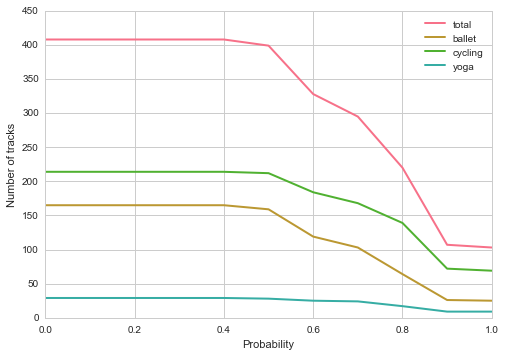

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_context("notebook")
sns.set_style("whitegrid")

# threshold values
xs = list(a / 10.0 for a in range(11))

# all classes
total = [len(prob_with_threshold(knn_pred, i)) for i in xs]
line_total = plt.plot(xs, total, linewidth=2, label='total')

for lb in labels:
    # label index
    lb_ind = labels.index(lb)
    # size of the class
    lb_size = [class_size(prob_with_threshold(knn_pred, 
                                              i))[lb_ind] for i in xs]
    line_lb = plt.plot(xs, lb_size, linewidth=2, label=lb)

plt.ylabel('Number of tracks')
plt.xlabel('Probability')
plt.legend()
plt.show()

Looking at the plot, I'd say that 0.8 is a good value for the probability threshold. It filters out almost half of the tracks by eliminating tracks with a lower certainty of class membership. Thus, the playlists are more accurate. 

I apply the 0.8 probability threshold to data and review the result.

In [23]:
def summary_of_prob_with_thres(model_pred, 
                               threshold, 
                               labels):
    """Print summary with a threshold applied to
    the model prediction.
    """
    model_thres = prob_with_threshold(model_pred, threshold)
    print ("Total number of tracks to classify: {}."
           "\nNumber of tracks with {} probability "
           "of class membership: {}, "
           "or {:.1%} of the initial assignment."
           .format(len(model_pred), 
                   threshold, 
                   len(model_thres),
                  (len(model_thres)/len(model_pred))))
    print "\nAmong which..."
    for lb in labels:
        # label index
        lb_ind = labels.index(lb)
        # size of the class
        lb_size = class_size(model_pred)[lb_ind]
        # size of the class with a threshold
        lb_thres_size = class_size(model_thres)[lb_ind]
        print ("...assigned the \"{}\" class: {} "
               "({:.1%} of the initial assignment.)"
               "\nMean probability for the class: {:.3f}. \n"
               .format(lb, lb_thres_size, 
                       (lb_thres_size / lb_size),
                       class_mean(model_thres, lb_ind)))

In [24]:
# print summary 
summary_of_prob_with_thres(knn_pred, 0.8, labels)

Total number of tracks to classify: 408.
Number of tracks with 0.8 probability of class membership: 220, or 53.9% of the initial assignment.

Among which...
...assigned the "ballet" class: 64 (38.8% of the initial assignment.)
Mean probability for the class: 0.917. 

...assigned the "cycling" class: 139 (65.0% of the initial assignment.)
Mean probability for the class: 0.935. 

...assigned the "yoga" class: 17 (58.6% of the initial assignment.)
Mean probability for the class: 0.935. 



54% of tracks have high probability of matching one of the three classes. By setting a 0.8 threshold, I increased the mean probability to 0.9. 

The "ballet" class lost more than 60% of tracks assigned this class initially. The "cycling" class lost only 35%, and the "yoga" class lost around 40% of tracks. 

### Summary
In this notebook I applied **k-neighbors classification** technique to identify class membership of every track in the matching group and assign a class label. I started by tuning model parameters using the scikit-learn tool GridSearchCV. I estimated model accuracy using K-fold cross validation.  

The estimated **model accuracy score** equals **0.742**.  

Model prediction results: 
* "ballet" class: 165, or 40.4% of all tracks.
* "cycling" class: 214, or 52.5% of all tracks.
* "yoga" class: 29, or 7.1% of all tracks.

The "cycling" class has the highest mean probability, which means that on average tracks are assigned this class with 83% certainty. At the same time, this is the most popular class — more than 50% of all tracks in the test set are assigned the "cycling" class. 

The "ballet" class is doing alright. 40% of all tracks are assigned this class label with 74% certainty on average. 

The "yoga" class has the fewest representatives in the test set. Only 29 tracks were assigned this class label. The mean probability, however, is rather high (81%).

I applied 0.8 probability threshold to model predictions of class membership. As a result, only 54% were left of the initial selection but the mean probability increased to 0.9. The "ballet" class lost more than 60% of tracks.

I saved all functions used in this notebook as a module 'estimator_handling.py'. I'm going to use it in the following notebooks. Data and results of this classification are stored in a HDF5 file. 

In the next post, I'm going to try [Random Forest Classifier](https://github.com/Tykovka/itunes-music-analysis/blob/master/06_Random_forest_classifier.ipynb).